### LORA Finetuning + Controlnet - Adapted from T2I Adapter

- Instead of using an adapter, you modify the UNet to accept 6 channels (3 for noisy latents + 3 for the upscaled Low-Res condition)
- The model has direct access to the LR pixels at the very first layer, allowing it to perform "residual learning"

The "VAE Bottleneck" (Critical Issue)
- SD1.5 does not see your pixels. It sees a compressed "latent" representation (64x64 latent for a 512x512 image). The VAE used in SD1.5 is lossy; it tends to blur high-frequency details (like bone trabeculae or vessel boundaries) during encoding.
- The Problem: Even if your T2I adapter works perfectly, the final image is generated from a latent that physically cannot represent the microscopic details you are trying to super-resolve.
- The Symptom: Loss stays flat because the model reaches the "limit" of the VAE's sharpness effectively immediately.

Noise Prediction ($\epsilon$) vs. Velocity ($v$)Standard SD predicts the noise ($\epsilon$).
- For SR, the input (Low Res) and output (High Res) are visually very similar.
- Predicting noise is "hard" because the model has to hallucinate details from pure Gaussian noise.
- Best Practice: Switch to v_prediction (predicting velocity) or $x_0$ prediction (predicting the image directly). This stabilizes training for image-to-image tasks where the input is strong.

In [ ]:
!pip install basicsr bitsandbytes monai nibabel nilearn SimpleITK torchmetrics scikit-image

In [ ]:
!wget https://raw.githubusercontent.com/Bernat-C/MRI-Diffusion-SuperResolution/main/adapters/utils.py
!wget https://raw.githubusercontent.com/Bernat-C/MRI-Diffusion-SuperResolution/main/adapters/modules.py
!wget https://raw.githubusercontent.com/Bernat-C/MRI-Diffusion-SuperResolution/main/adapters/datasets.py

In [ ]:
import argparse
import functools
import gc
import logging
import math
import os
import random
import shutil
from pathlib import Path
import wandb

import accelerate
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed
from datasets import load_dataset
from huggingface_hub import create_repo, upload_folder
from packaging import version
from PIL import Image
from torchvision import transforms
from tqdm.autonotebook import tqdm
from transformers import AutoTokenizer, PretrainedConfig
import matplotlib.pyplot as plt

import diffusers
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    UNet2DConditionModel,
    UniPCMultistepScheduler,
)
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available
from diffusers.training_utils import EMAModel

from omegaconf import OmegaConf
import cv2
from huggingface_hub import hf_hub_url
import subprocess
import shlex

from utils import (import_model_class_from_model_name_or_path, log_configs, encode_prompt_sd1x5, compute_embeddings_sd1x5)

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


In [ ]:
# Hack to fix https://github.com/XPixelGroup/BasicSR/pull/650
!sed -i 's/from torchvision.transforms.functional_tensor import rgb_to_grayscale/from torchvision.transforms.functional import rgb_to_grayscale/' /usr/local/lib/python3.12/dist-packages/basicsr/data/degradations.py

### Setup Config

In [ ]:
%%writefile config.xyz
pretrained_model_name_or_path: "sd-legacy/stable-diffusion-v1-5"
pretrained_vae_model_name_or_path: null
revision: null
tokenizer_name: null
output_dir: '/content/drive/MyDrive/GenAI/artificial-nolora'
data_dir: ['/content/drive/MyDrive/GenAI/Data/rawdata_BIDS_3T.zip']
slice_axis: 1
seed: 42
modality:
resolution: 512
crops_coords_top_left_h: 0
crops_coords_top_left_w: 0
train_batch_size: 32
num_train_epochs: 100
max_train_steps: 2000
checkpointing_steps: 200
gradient_accumulation_steps: 1
gradient_checkpointing: true
learning_rate: 1e-5
scale_lr: false
config: ""
lr_scheduler_name: "cosine"
lr_warmup_steps: 500
lr_num_cycles: 1
lr_power: 1.0
use_8bit_adam: true
dataloader_num_workers: 0
adam_beta1: 0.9
adam_beta2: 0.999
adam_weight_decay: 1e-2
adam_epsilon: 1e-08
max_grad_norm: 1.0
logging_dir: '/content/drive/MyDrive/GenAI/artificial-nolora/logs'
allow_tf32: false
report_to: "wandb"
mixed_precision: null
enable_xformers_memory_efficient_attention: false
set_grads_to_none: false
proportion_empty_prompts: 0.1
tracker_project_name: "mri_t2i_adapter_v1.5"
ddpm_scheduler_prediction_type: "v_prediction"
ddpm_scheduler_timestep_spacing: "trailing"
ddpm_scheduler_rescale_betas_zero_snr: True
lora_alpha: 32
lora_rank: 8

Writing config.xyz


In [ ]:
import yaml
from argparse import Namespace
import re

# Hack to read 1e-2 as number and not as string
loader = yaml.SafeLoader
loader.add_implicit_resolver(
    u'tag:yaml.org,2002:float',
    re.compile(u'''^(?:
     [-+]?(?:[0-9][0-9_]*)\\.[0-9_]*(?:[eE][-+]?[0-9]+)?
    |[-+]?(?:[0-9][0-9_]*)(?:[eE][-+]?[0-9]+)
    |\\.[0-9_]+(?:[eE][-+][0-9]+)?
    |[-+]?[0-9][0-9_]*(?::[0-5]?[0-9])+\\.[0-9_]*
    |[-+]?\\.(?:inf|Inf|INF)
    |\\.(?:nan|NaN|NAN))$''', re.X),
    list(u'-+0123456789.'))

# Load the config as a dictionary (from the example above)
with open('config.xyz', 'r') as file:
    config_dict = yaml.load(file, Loader=loader)

# --- Convert the dictionary to a Namespace object ---
args = Namespace(**config_dict)

### Function Defs

In [ ]:
def import_model_class_from_model_name_or_path(
    pretrained_model_name_or_path: str, revision: str, subfolder: str = "text_encoder"
):
    text_encoder_config = PretrainedConfig.from_pretrained(
        pretrained_model_name_or_path, subfolder=subfolder, revision=revision
    )
    model_class = text_encoder_config.architectures[0]

    if model_class == "CLIPTextModel":
        from transformers import CLIPTextModel

        return CLIPTextModel
    elif model_class == "CLIPTextModelWithProjection":
        from transformers import CLIPTextModelWithProjection

        return CLIPTextModelWithProjection
    else:
        raise ValueError(f"{model_class} is not supported.")

# Adapted from pipelines.StableDiffusionXLPipeline.encode_prompt
def encode_prompt(prompt_batch, text_encoders, tokenizers, proportion_empty_prompts, is_train=True):
    prompt_embeds_list = []

    captions = []
    for caption in prompt_batch:
        if random.random() < proportion_empty_prompts:
            captions.append("")
        elif isinstance(caption, str):
            captions.append(caption)
        elif isinstance(caption, (list, np.ndarray)):
            # take a random caption if there are multiple
            captions.append(random.choice(caption) if is_train else caption[0])

    with torch.no_grad():
        for tokenizer, text_encoder in zip(tokenizers, text_encoders):
            text_inputs = tokenizer(
                captions,
                padding="max_length",
                max_length=tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            )
            text_input_ids = text_inputs.input_ids
            prompt_embeds = text_encoder(
                text_input_ids.to(text_encoder.device),
                output_hidden_states=True,
            )

            # We are only ALWAYS interested in the pooled output of the final text encoder
            pooled_prompt_embeds = prompt_embeds[0]
            prompt_embeds = prompt_embeds.hidden_states[-2]
            bs_embed, seq_len, _ = prompt_embeds.shape
            prompt_embeds = prompt_embeds.view(bs_embed, seq_len, -1)
            prompt_embeds_list.append(prompt_embeds)

    prompt_embeds = torch.concat(prompt_embeds_list, dim=-1)
    pooled_prompt_embeds = pooled_prompt_embeds.view(bs_embed, -1)
    return prompt_embeds, pooled_prompt_embeds


# Simplified encode_prompt for SD1.5 (replace your existing function)
def encode_prompt_sd1x5(prompt_batch, text_encoders, tokenizers, proportion_empty_prompts, is_train=True):
    captions = []
    for caption in prompt_batch:
        if random.random() < proportion_empty_prompts: # CFG Dropout enabled here!
            captions.append("")
        elif isinstance(caption, str):
            captions.append(caption)
        elif isinstance(caption, (list, np.ndarray)):
            captions.append(random.choice(caption) if is_train else caption[0])

    # SD1.5 only uses the first (and only) text encoder/tokenizer
    tokenizer = tokenizers[0]
    text_encoder = text_encoders[0]

    with torch.no_grad():
        text_inputs = tokenizer(
            captions,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_input_ids = text_inputs.input_ids
        # SD1.5 uses the last hidden state of the standard CLIP Text Model
        prompt_embeds = text_encoder(
            text_input_ids.to(text_encoder.device),
            # SD1.5 does NOT need output_hidden_states=True
        )[0] # [0] extracts the prompt_embeds from the tuple
    return prompt_embeds # Shape: [B, 77, 768]


# Simplified compute_embeddings for SD1.5 (replace your existing function)
def compute_embeddings_sd1x5(batch, proportion_empty_prompts, text_encoders, tokenizers, is_train=True):
    prompt_batch = batch['txt']

    # Now calls the simplified SD1.5 encoder
    prompt_embeds = encode_prompt_sd1x5(
        prompt_batch, text_encoders, tokenizers, proportion_empty_prompts, is_train
    )

    prompt_embeds = prompt_embeds.to(accelerator.device)

    # SD1.5 UNet only needs the prompt_embeds tensor
    return {"prompt_embeds": prompt_embeds} # Return only the required embedding


# Here, we compute not just the text embeddings but also the additional embeddings
# needed for the SD XL UNet to operate.
def compute_embeddings(batch, proportion_empty_prompts, text_encoders, tokenizers, is_train=True):
    original_size = (args.resolution, args.resolution)
    target_size = (args.resolution, args.resolution)
    crops_coords_top_left = (args.crops_coords_top_left_h, args.crops_coords_top_left_w)
    prompt_batch = batch['txt']
    prompt_embeds, pooled_prompt_embeds = encode_prompt(
        prompt_batch, text_encoders, tokenizers, proportion_empty_prompts, is_train
    )
    add_text_embeds = pooled_prompt_embeds
    # Adapted from pipeline.StableDiffusionXLPipeline._get_add_time_ids
    add_time_ids = list(original_size + crops_coords_top_left + target_size)
    add_time_ids = torch.tensor([add_time_ids])
    prompt_embeds = prompt_embeds.to(accelerator.device)
    add_text_embeds = add_text_embeds.to(accelerator.device)
    add_time_ids = add_time_ids.repeat(len(prompt_batch), 1)
    add_time_ids = add_time_ids.to(accelerator.device, dtype=prompt_embeds.dtype)
    unet_added_cond_kwargs = {"text_embeds": add_text_embeds, "time_ids": add_time_ids}
    return {"prompt_embeds": prompt_embeds}, unet_added_cond_kwargs

In [ ]:
import torch
import torch.nn as nn


def conv_nd(dims, *args, **kwargs):
    """
    Create a 1D, 2D, or 3D convolution module.
    """
    if dims == 1:
        return nn.Conv1d(*args, **kwargs)
    elif dims == 2:
        return nn.Conv2d(*args, **kwargs)
    elif dims == 3:
        return nn.Conv3d(*args, **kwargs)
    raise ValueError(f"unsupported dimensions: {dims}")


def avg_pool_nd(dims, *args, **kwargs):
    """
    Create a 1D, 2D, or 3D average pooling module.
    """
    if dims == 1:
        return nn.AvgPool1d(*args, **kwargs)
    elif dims == 2:
        return nn.AvgPool2d(*args, **kwargs)
    elif dims == 3:
        return nn.AvgPool3d(*args, **kwargs)
    raise ValueError(f"unsupported dimensions: {dims}")

def get_parameter_dtype(parameter: torch.nn.Module):
    try:
        params = tuple(parameter.parameters())
        if len(params) > 0:
            return params[0].dtype

        buffers = tuple(parameter.buffers())
        if len(buffers) > 0:
            return buffers[0].dtype

    except StopIteration:
        # For torch.nn.DataParallel compatibility in PyTorch 1.5

        def find_tensor_attributes(module: torch.nn.Module) -> List[Tuple[str, Tensor]]:
            tuples = [(k, v) for k, v in module.__dict__.items() if torch.is_tensor(v)]
            return tuples

        gen = parameter._named_members(get_members_fn=find_tensor_attributes)
        first_tuple = next(gen)
        return first_tuple[1].dtype

class Downsample(nn.Module):
    """
    A downsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 downsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv, dims=2, out_channels=None, padding=1):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.dims = dims
        stride = 2 if dims != 3 else (1, 2, 2)
        if use_conv:
            self.op = conv_nd(dims, self.channels, self.out_channels, 3, stride=stride, padding=padding)
        else:
            assert self.channels == self.out_channels
            self.op = avg_pool_nd(dims, kernel_size=stride, stride=stride)

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)


class ResnetBlock(nn.Module):

    def __init__(self, in_c, out_c, down, ksize=3, sk=False, use_conv=True):
        super().__init__()
        ps = ksize // 2
        if in_c != out_c or sk == False:
            self.in_conv = nn.Conv2d(in_c, out_c, ksize, 1, ps)
        else:
            self.in_conv = None
        self.block1 = nn.Conv2d(out_c, out_c, 3, 1, 1)
        self.act = nn.ReLU()
        self.block2 = nn.Conv2d(out_c, out_c, ksize, 1, ps)
        if sk == False:
            self.skep = nn.Conv2d(in_c, out_c, ksize, 1, ps)
        else:
            self.skep = None

        self.down = down
        if self.down == True:
            self.down_opt = Downsample(in_c, use_conv=use_conv)

    def forward(self, x):
        if self.down == True:
            x = self.down_opt(x)
        if self.in_conv is not None:  # edit
            x = self.in_conv(x)
        h = self.block1(x)
        h = self.act(h)
        h = self.block2(h)
        if self.skep is not None:
            return h + self.skep(x)
        else:
            return h + x


class Adapter_XL(nn.Module):

    def __init__(self, channels=[320, 640, 1280, 1280], nums_rb=3, cin=192, ksize=3, sk=False, use_conv=True):
        super(Adapter_XL, self).__init__()
        self.unshuffle = nn.PixelUnshuffle(8)
        self.channels = channels
        self.nums_rb = nums_rb
        self.body = []
        for i in range(len(channels)):
            for j in range(nums_rb):
                if (i == 2) and (j == 0):
                    self.body.append(
                        ResnetBlock(channels[i - 1], channels[i], down=True, ksize=ksize, sk=sk, use_conv=use_conv))
                elif (i == 1) and (j == 0):
                    self.body.append(
                        ResnetBlock(channels[i - 1], channels[i], down=True, ksize=ksize, sk=sk, use_conv=use_conv))
                elif (i == 3) and (j == 0):
                    self.body.append(
                        ResnetBlock(channels[i - 1], channels[i], down=True, ksize=ksize, sk=sk, use_conv=use_conv))
                else:
                    self.body.append(
                        ResnetBlock(channels[i], channels[i], down=False, ksize=ksize, sk=sk, use_conv=use_conv))
        self.body = nn.ModuleList(self.body)
        self.conv_in = nn.Conv2d(cin, channels[0], 3, 1, 1)

    @property
    def dtype(self) -> torch.dtype:
        """
        `torch.dtype`: The dtype of the module (assuming that all the module parameters have the same dtype).
        """
        return get_parameter_dtype(self)

    def forward(self, x):
        # unshuffle
        x = self.unshuffle(x)
        # extract features
        features = []
        x = self.conv_in(x)
        for i in range(len(self.channels)):
            for j in range(self.nums_rb):
                idx = i * self.nums_rb + j
                x = self.body[idx](x)
            features.append(x)
        return features



In [ ]:
from transformers import PretrainedConfig

def import_model_class_from_model_name_or_path(pretrained_model_name_or_path: str, revision: str, subfolder: str = "text_encoder"):
    # This reads the config file from the HF Hub or local path
    text_encoder_config = PretrainedConfig.from_pretrained(
        pretrained_model_name_or_path,
        subfolder=subfolder,
        revision=revision,
    )

    model_class = text_encoder_config.architectures[0]

    if model_class == "CLIPTextModel":
        from transformers import CLIPTextModel
        return CLIPTextModel

    else:
        raise ValueError(f"{model_class} is not supported.")

### Setup Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/GenAI/Data/rawdata_BIDS_3T.zip -d ./

Archive:  /content/drive/MyDrive/GenAI/Data/rawdata_BIDS_3T.zip
   creating: ./rawdata_BIDS_3T/
  inflating: ./rawdata_BIDS_3T/.bidsignore  
   creating: ./rawdata_BIDS_3T/code/
   creating: ./rawdata_BIDS_3T/code/bidscoin/
 extracting: ./rawdata_BIDS_3T/code/bidscoin/bidscoiner.errors  
  inflating: ./rawdata_BIDS_3T/code/bidscoin/bidscoiner.log  
  inflating: ./rawdata_BIDS_3T/code/bidscoin/bidscoiner.tsv  
  inflating: ./rawdata_BIDS_3T/code/bidscoin/bidsmap.yaml  
 extracting: ./rawdata_BIDS_3T/code/bidscoin/bidsmapper.errors  
  inflating: ./rawdata_BIDS_3T/code/bidscoin/bidsmapper.log  
   creating: ./rawdata_BIDS_3T/code/bidscoin/provenance/
   creating: ./rawdata_BIDS_3T/code/bidscoin/provenance/DICOM/
   creating: ./rawdata_BIDS_3T/code/bidscoin/provenance/DICOM/3T-ALL/
   creating: ./rawdata_BIDS_3T/code/bidscoin/provenance/DICOM/3T-ALL/3T/
   creating: ./rawdata_BIDS_3T/code/bidscoin/provenance/DICOM/3T-ALL/3T/sub-01/
   creating: ./rawdata_BIDS_3T/code/bidscoin/provenance/D

In [ ]:
# !unzip /content/drive/MyDrive/GenAI/Data/rawdata_BIDS_7T.zip -d ./

In [ ]:
!mkdir ./mri_dataset

In [ ]:
!mv rawdata_BIDS_3T/ mri_dataset/
#!mv rawdata_BIDS_7T/ mri_dataset/

In [ ]:
import os
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import SimpleITK as sitk

def get_data_dicts_artificial(data_dir, modality="T2w"):
    """
    Parses BIDS structure to find 3T instances.
    Sets 'hr' as the original 3T path and 'lr' as the same 3T path.
    The actual downsampling/degradation should be performed in the
    Dataset's __getitem__ or preprocessing step.
    """
    data_dir = Path(data_dir)
    # We only need the 3T base for this specific task
    lr_base = data_dir / 'rawdata_BIDS_3T'
    data_dicts = []

    # Iterate through 3T subjects
    for subject_dir in lr_base.glob('sub-*'):
        subject_id = subject_dir.name

        # Find the 3T files for the specific modality
        t3_files = list((subject_dir / 'anat').glob(f'*{modality}*.nii*'))

        if t3_files:
            # Both HR and LR point to the 3T file
            # The Dataset class will take this path and create a degraded version for 'lr'
            t3_path = str(t3_files[0])

            # Updated prompt: removed "7T" since we are using 3T as ground truth
            prompt = f"high quality MRI scan, {modality} brain slice, 3T field strength, precise anatomical details, sharp focus, medical imaging"

            data_dicts.append({
                'lr': t3_path,         # This will be downsampled later
                'hr': t3_path,         # This remains the original target
                'txt': prompt,
                'subject_id': subject_id
            })

    print(f"Found {len(data_dicts)} 3T subjects for downsampling task.")
    return data_dicts

def n4_bias_correction(sitk_image, shrink_factor=2):
    """Simple N4 bias correction wrapper (optional)."""
    maskImage = sitk.OtsuThreshold(sitk_image, 0, 1, 200)
    inputImage = sitk_image
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrected = corrector.Execute(inputImage, maskImage)
    return corrected


def rigid_register_and_resample(fixed_img_sitk, moving_img_sitk, do_n4=False, verbose=False):
    """
    Registers `moving` to `fixed` (rigid) and resamples moving into fixed's physical grid.
    Returns: resampled_moving_sitk (SimpleITK image)
    """
    fixed_img_sitk  = sitk.Cast(fixed_img_sitk,  sitk.sitkFloat32)
    moving_img_sitk = sitk.Cast(moving_img_sitk, sitk.sitkFloat32)
    if do_n4:
        if verbose: print("Applying N4 bias correction to fixed and moving.")
        fixed_img_sitk = n4_bias_correction(fixed_img_sitk)
        moving_img_sitk = n4_bias_correction(moving_img_sitk)

    # Initial alignment using geometry center
    initial_transform = sitk.CenteredTransformInitializer(
        fixed_img_sitk,
        moving_img_sitk,
        sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY
    )

    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.05)
    registration_method.SetInterpolator(sitk.sitkLinear)
    registration_method.SetOptimizerAsRegularStepGradientDescent(
        learningRate=2.0,
        minStep=1e-4,
        numberOfIterations=200,
        gradientMagnitudeTolerance=1e-8
    )
    registration_method.SetOptimizerScalesFromPhysicalShift()
    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    registration_method.Execute(fixed_img_sitk, moving_img_sitk)

    final_transform = registration_method.GetInitialTransform()
    # Actually registration_method modifies the transform; retrieve it:
    try:
        final_transform = registration_method.GetInitialTransform()
    except Exception:
        final_transform = initial_transform

    # Resample moving to fixed grid using computed transform
    resampled_moving = sitk.Resample(
        moving_img_sitk,
        fixed_img_sitk,            # reference image (sets size, spacing, origin, direction)
        final_transform,
        sitk.sitkLinear,
        0.0,
        moving_img_sitk.GetPixelID()
    )
    return resampled_moving


def sitk_to_tensor(img_sitk):
    """Convert SITK image (z,y,x) -> torch tensor [1, H, W, D] (MONAI style [C,H,W,D])"""
    arr = sitk.GetArrayFromImage(img_sitk).astype(np.float32)  # shape (D, H, W)
    # Convert to (H, W, D)
    # We'll keep order (H, W, D) for stacking later; MONAI expects [C, H, W, D]
    D, H, W = arr.shape
    arr = arr.transpose(1, 2, 0)  # (H, W, D)
    # add channel axis -> (1, H, W, D)
    arr = np.expand_dims(arr, axis=0)
    tensor = torch.from_numpy(arr)
    return tensor


def get_valid_z_range_from_mask(mask_sitk, min_fraction=0.01):
    """
    Given a binary mask SITK image [size=(nx,ny,nz)], compute the z-range
    with slices having at least min_fraction of foreground pixels.
    Returns (z0, z1) inclusive indexes in SITK indexing (0..nz-1).
    """
    mask_np = sitk.GetArrayFromImage(mask_sitk).astype(np.uint8)  # shape (D, H, W)
    D, H, W = mask_np.shape
    per_slice_counts = mask_np.reshape(D, -1).sum(axis=1)  # length D
    min_pixels = int(min_fraction * (H * W))
    # find indices where count >= min_pixels
    good_idx = np.where(per_slice_counts >= min_pixels)[0]
    if len(good_idx) == 0:
        # fallback: use central 50% of slices if Otsu failed
        z0 = D // 4
        z1 = 3 * D // 4
    else:
        z0 = int(good_idx[0])
        z1 = int(good_idx[-1])
    # Convert from SITK array indexing (D,H,W) -> our (H,W,D) indexing when cropping later
    return z0, z1  # indices along D (axial index in sitk array order)


def crop_volume_along_z_np(np_vol_hw_d, z0, z1, axis_is_hw_d=True):
    """
    np_vol_hw_d: numpy array in shape (H, W, D) OR (1,H,W,D) -> keep in mind caller
    We'll return cropped (H, W, D) (or with leading channel preserved).
    The z0,z1 are indices in the D axis (0..D-1).
    """
    TARGET_H = 512
    TARGET_W = 512

    if np_vol_hw_d.ndim == 4:  # (1,H,W,D)
        channel = np_vol_hw_d[0]
        cropped = channel[:, :, z0:(z1+1)]
        return np.expand_dims(cropped, 0)
    elif np_vol_hw_d.ndim == 3:  # (H,W,D)
        return np_vol_hw_d[:, :, z0:(z1+1)]
    else:
        raise ValueError("Unexpected array dims")

def pad_or_center_crop(tensor2d):
        TARGET_H = 512
        TARGET_W = 512
        H, W = tensor2d.shape
        # Center-crop if larger than target
        if H > TARGET_H:
            start_h = (H - TARGET_H) // 2
            tensor2d = tensor2d[start_h:start_h + TARGET_H, :]
            H = TARGET_H
        if W > TARGET_W:
            start_w = (W - TARGET_W) // 2
            tensor2d = tensor2d[:, start_w:start_w + TARGET_W]
            W = TARGET_W

        pad_h = max(0, TARGET_H - H)
        pad_w = max(0, TARGET_W - W)
        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top
        pad_left = pad_w // 2
        pad_right = pad_w - pad_left

        if pad_h > 0 or pad_w > 0:
            import torch.nn.functional as F
            # F.pad expects (pad_left, pad_right, pad_top, pad_bottom)
            tensor2d = F.pad(tensor2d.unsqueeze(0), (pad_left, pad_right, pad_top, pad_bottom), mode='constant', value=0.0).squeeze(0)

        return tensor2d


class SliceDataset(Dataset):
    def __init__(self, pairs, slice_axis=2, cache_dir='./cache', do_registration=True, do_n4=False, lr_clip=(0, 2000), hr_clip=(0, 900)):
        """
        Args:
            pairs: A list of dicts (from get_data_dicts_artificial) to be used by this instance.
            slice_axis: 0=sagittal,1=coronal,2=axial
            cache_dir: where to store resampled numpy .npz caches per subject
            do_registration: perform rigid registration LR->HR (recommended True)
            do_n4: apply N4 bias correction prior to registration (optional)
            intensity_clip: (a_min, a_max) for intensity normalization to [0,1]
        """
        self.pairs = pairs
        self.slice_axis = slice_axis
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(parents=True, exist_ok=True)
        self.do_registration = do_registration
        self.do_n4 = do_n4
        self.lr_clip = lr_clip
        self.hr_clip = hr_clip

        if not self.pairs:
            raise ValueError("No pairs found. Check paths.")

        # Preprocess & cache
        self.slice_metadata = []
        self._prepare_all_pairs()

    def _prepare_all_pairs(self):
        print("Preparing pairs (registration/resampling + caching).")
        for item in self.pairs:
            sid = item['subject_id']
            if sid == 'sub-15':
              print(f'Skipping subject 15 due to wrong layout')
              continue
            cache_file = self.cache_dir / f"{sid}_resampled.npz"
            if cache_file.exists():
                npz = np.load(cache_file)
                hr_arr = npz['hr']  # shape [1,H,W,D]
                lr_arr = npz['lr']
            else:
                # Read with SimpleITK
                hr_sitk = sitk.ReadImage(item['hr'])
                lr_sitk = sitk.ReadImage(item['lr'])

                # Optionally register and resample
                if self.do_registration:
                    try:
                        lr_resampled_sitk = rigid_register_and_resample(hr_sitk, lr_sitk, do_n4=self.do_n4, verbose=False)
                    except Exception as e:
                        print(f"Registration failed for {sid}: {e}. Falling back to simple resample onto HR grid.")
                        lr_resampled_sitk = sitk.Resample(lr_sitk, hr_sitk, sitk.Transform(), sitk.sitkLinear, 0.0, lr_sitk.GetPixelID())
                else:
                    # Direct resample (no registration) onto HR grid
                    lr_resampled_sitk = sitk.Resample(lr_sitk, hr_sitk, sitk.Transform(), sitk.sitkLinear, 0.0, lr_sitk.GetPixelID())

                # Optionally resample HR itself to a smaller target spacing if wanted.
                # For now we keep HR as original 7T grid (so hr_sitk defines canonical grid)

                # Convert to numpy/tensors (and normalize intensities)
                hr_tensor = sitk_to_tensor(hr_sitk)   # [1,H,W,D]
                lr_tensor = sitk_to_tensor(lr_resampled_sitk)

                hr_arr = hr_tensor.numpy().astype(np.float32)
                lr_arr = lr_tensor.numpy().astype(np.float32)

                # Crop first/last 30 slices along chosen slice_axis to remove 'air'
                dim_idx = self.slice_axis + 1  # mapping into [C,H,W,D] array
                num_slices = hr_arr.shape[dim_idx]
                crop_start = 80
                crop_end = num_slices - 30
                if crop_end <= crop_start or num_slices <= 60:
                    # Fallback: don't crop if not enough slices
                    print(f"Subject {sid}: volume too small ({num_slices} slices) to crop 30/30, skipping crop.")
                else:
                    slicer = [slice(None)] * hr_arr.ndim
                    slicer[dim_idx] = slice(crop_start, crop_end)
                    hr_arr = hr_arr[tuple(slicer)]
                    lr_arr = lr_arr[tuple(slicer)]

                # Intensity clipping and scaling to [0,1]
                # a_min, a_max = self.intensity_clip
                # hr_arr = hr_tensor.numpy().astype(np.float32)
                # lr_arr = lr_tensor.numpy().astype(np.float32)
                # hr_arr = np.clip((hr_arr - a_min) / (a_max - a_min), 0.0, 1.0)
                # lr_arr = np.clip((lr_arr - a_min) / (a_max - a_min), 0.0, 1.0)

                a_min_hr, a_max_hr = float(self.hr_clip[0]), float(self.hr_clip[1])
                a_min_lr, a_max_lr = float(self.lr_clip[0]), float(self.lr_clip[1])
                # final clamp and cast
                hr_arr = np.clip((hr_arr - a_min_hr) / (a_max_hr - a_min_hr), 0.0, 1.0).astype(np.float32)
                lr_arr = np.clip((lr_arr - a_min_lr) / (a_max_lr - a_min_lr), 0.0, 1.0).astype(np.float32)

                # Save cache
                np.savez_compressed(cache_file, hr=hr_arr, lr=lr_arr)

            # Now create slice metadata entries
            # hr_arr shape: [1, H, W, D]
            num_slices = hr_arr.shape[self.slice_axis + 1]  # channel + dims
            for s_idx in range(num_slices):
                self.slice_metadata.append({
                    'hr_arr': hr_arr,
                    'lr_arr': lr_arr,
                    'slice_idx': int(s_idx),
                    'txt': item['txt'],
                    'subject_id': sid
                })

    def _prepare_all_pairs(self):
        print("Preparing pairs (3T Downsampling + caching).")
        # Define the downsampling factor (e.g., 4x)
        DS_FACTOR = 4.0

        for item in self.pairs:
            sid = item['subject_id']
            if sid == 'sub-15': continue

            cache_file = self.cache_dir / f"{sid}_3T_downsampled.npz"
            if cache_file.exists():
                npz = np.load(cache_file)
                hr_arr = npz['hr']
                lr_arr = npz['lr']
            elif item['lr'] == item['hr']:
                # 1. Load the 3T image (item['hr'] and item['lr'] both point here now)
                hr_sitk = sitk.ReadImage(item['hr'])
                hr_sitk = sitk.Cast(hr_sitk, sitk.sitkFloat32)

                # 2. Create the Low-Res (LR) version
                # Anti-aliasing: Blur before downsampling to simulate lower-res physics
                sigma = (DS_FACTOR / 2.0)
                blurred_sitk = sitk.DiscreteGaussian(hr_sitk, variance=sigma**2)

                # Calculate new dimensions for the "true" low-res space
                orig_spacing = hr_sitk.GetSpacing()
                orig_size = hr_sitk.GetSize()
                new_spacing = [s * DS_FACTOR for s in orig_spacing]
                new_size = [int(sz / DS_FACTOR) for sz in orig_size]

                # Step A: Resample down to low-res grid
                lr_low_res = sitk.Resample(
                    blurred_sitk,
                    new_size,
                    sitk.Transform(),
                    sitk.sitkLinear,
                    hr_sitk.GetOrigin(),
                    new_spacing,
                    hr_sitk.GetDirection(),
                    0.0,
                    hr_sitk.GetPixelID()
                )

                # Step B: Resample back up to the HR grid (so tensors match shape)
                # We use Linear interpolation to simulate what a basic upscaler would do
                lr_resampled_sitk = sitk.Resample(
                    lr_low_res,
                    hr_sitk, # Use original HR as reference grid
                    sitk.Transform(),
                    sitk.sitkLinear,
                    0.0,
                    hr_sitk.GetPixelID()
                )

                # 3. Convert to numpy/tensors
                hr_tensor = sitk_to_tensor(hr_sitk)
                lr_tensor = sitk_to_tensor(lr_resampled_sitk)

                hr_arr = hr_tensor.numpy().astype(np.float32)
                lr_arr = lr_tensor.numpy().astype(np.float32)

                # 4. Crop slices along chosen slice_axis (same as your original code)
                dim_idx = self.slice_axis + 1
                num_slices = hr_arr.shape[dim_idx]
                crop_start, crop_end = 80, num_slices - 30

                if crop_end > crop_start and num_slices > 60:
                    slicer = [slice(None)] * hr_arr.ndim
                    slicer[dim_idx] = slice(crop_start, crop_end)
                    hr_arr = hr_arr[tuple(slicer)]
                    lr_arr = lr_arr[tuple(slicer)]

                # 5. Intensity clipping and scaling to [0,1]
                a_min_hr, a_max_hr = float(self.hr_clip[0]), float(self.hr_clip[1])
                a_min_lr, a_max_lr = float(self.lr_clip[0]), float(self.lr_clip[1])

                hr_arr = np.clip((hr_arr - a_min_hr) / (a_max_hr - a_min_hr), 0.0, 1.0).astype(np.float32)
                lr_arr = np.clip((lr_arr - a_min_lr) / (a_max_lr - a_min_lr), 0.0, 1.0).astype(np.float32)

                # Save cache
                np.savez_compressed(cache_file, hr=hr_arr, lr=lr_arr)
            else:
                # Read with SimpleITK
                hr_sitk = sitk.ReadImage(item['hr'])
                lr_sitk = sitk.ReadImage(item['lr'])

                # Optionally register and resample
                if self.do_registration:
                    try:
                        lr_resampled_sitk = rigid_register_and_resample(hr_sitk, lr_sitk, do_n4=self.do_n4, verbose=False)
                    except Exception as e:
                        print(f"Registration failed for {sid}: {e}. Falling back to simple resample onto HR grid.")
                        lr_resampled_sitk = sitk.Resample(lr_sitk, hr_sitk, sitk.Transform(), sitk.sitkLinear, 0.0, lr_sitk.GetPixelID())
                else:
                    # Direct resample (no registration) onto HR grid
                    lr_resampled_sitk = sitk.Resample(lr_sitk, hr_sitk, sitk.Transform(), sitk.sitkLinear, 0.0, lr_sitk.GetPixelID())

                # Optionally resample HR itself to a smaller target spacing if wanted.
                # For now we keep HR as original 7T grid (so hr_sitk defines canonical grid)

                # Convert to numpy/tensors (and normalize intensities)
                hr_tensor = sitk_to_tensor(hr_sitk)   # [1,H,W,D]
                lr_tensor = sitk_to_tensor(lr_resampled_sitk)

                hr_arr = hr_tensor.numpy().astype(np.float32)
                lr_arr = lr_tensor.numpy().astype(np.float32)

                # Crop first/last 30 slices along chosen slice_axis to remove 'air'
                dim_idx = self.slice_axis + 1  # mapping into [C,H,W,D] array
                num_slices = hr_arr.shape[dim_idx]
                crop_start = 80
                crop_end = num_slices - 30
                if crop_end <= crop_start or num_slices <= 60:
                    # Fallback: don't crop if not enough slices
                    print(f"Subject {sid}: volume too small ({num_slices} slices) to crop 30/30, skipping crop.")
                else:
                    slicer = [slice(None)] * hr_arr.ndim
                    slicer[dim_idx] = slice(crop_start, crop_end)
                    hr_arr = hr_arr[tuple(slicer)]
                    lr_arr = lr_arr[tuple(slicer)]

                # Intensity clipping and scaling to [0,1]
                # a_min, a_max = self.intensity_clip
                # hr_arr = hr_tensor.numpy().astype(np.float32)
                # lr_arr = lr_tensor.numpy().astype(np.float32)
                # hr_arr = np.clip((hr_arr - a_min) / (a_max - a_min), 0.0, 1.0)
                # lr_arr = np.clip((lr_arr - a_min) / (a_max - a_min), 0.0, 1.0)

                a_min_hr, a_max_hr = float(self.hr_clip[0]), float(self.hr_clip[1])
                a_min_lr, a_max_lr = float(self.lr_clip[0]), float(self.lr_clip[1])
                # final clamp and cast
                hr_arr = np.clip((hr_arr - a_min_hr) / (a_max_hr - a_min_hr), 0.0, 1.0).astype(np.float32)
                lr_arr = np.clip((lr_arr - a_min_lr) / (a_max_lr - a_min_lr), 0.0, 1.0).astype(np.float32)

                # Save cache
                np.savez_compressed(cache_file, hr=hr_arr, lr=lr_arr)


            # Create slice metadata entries...
            num_slices = hr_arr.shape[self.slice_axis + 1]
            for s_idx in range(num_slices):
                self.slice_metadata.append({
                    'hr_arr': hr_arr, 'lr_arr': lr_arr, 'slice_idx': int(s_idx),
                    'txt': item['txt'], 'subject_id': sid
                })

    def __len__(self):
        return len(self.slice_metadata)

    def __getitem__(self, idx):
        m = self.slice_metadata[idx]
        hr = torch.from_numpy(m['hr_arr']).float()  # [1,H,W,D]
        lr = torch.from_numpy(m['lr_arr']).float()
        s = m['slice_idx']

        # Build slicing tuple for [C, H, W, D]
        slicer = [slice(None), slice(None), slice(None), slice(None)]
        slicer[self.slice_axis + 1] = s
        hr_slice = hr[tuple(slicer)].squeeze(0)  # [H, W] or [H, W] if 2D slice
        lr_slice = lr[tuple(slicer)].squeeze(0)
        #hr_flat = hr_slice.reshape(-1)
        ## guard against empty / degenerate slices
        #if hr_flat.numel() > 0:
        #    p_low = torch.quantile(hr_flat, 0.01)
        #    p_high = torch.quantile(hr_flat, 0.99)
        #    if p_high > p_low:
        #        hr_slice = (hr_slice - p_low) / (p_high - p_low)
        #    else:
        #        # constant slice -> zeros
        #        hr_slice = torch.zeros_like(hr_slice)
        #hr_slice = torch.clamp(hr_slice, 0.0, 1.0)

        hr_slice = pad_or_center_crop(hr_slice)
        lr_slice = pad_or_center_crop(lr_slice)

        # If you want explicit shape [1,H,W], add channel back
        hr_slice = hr_slice.unsqueeze(0)  # [1,H,W]
        lr_slice = lr_slice.unsqueeze(0)

        return {'hr': hr_slice, 'lr': lr_slice, 'txt': m['txt'], 'subject_id': m['subject_id']}

# ---------------------------------------------------------
# 3. Configuration & Execution
# ---------------------------------------------------------
from sklearn.model_selection import train_test_split

# Define Parameters
# 3T/7T are usually better aligned in Coronal/Sagittal for this specific dataset description
# Axial = 2, Coronal = 1, Sagittal = 0
SELECTED_AXIS = 1
TARGET_VOL_SIZE = (256, 256, 256) # Resize everything to this cube

# Initialize
dataset_path = Path('./mri_dataset/') # Ensure this contains 'rawdata_BIDS_3T' etc.

# Get all subject pairs
all_pairs = get_data_dicts_artificial(dataset_path)

# Split SUBJECTS first
train_pairs, val_pairs = train_test_split(all_pairs, test_size=0.2, random_state=42)

# Create separate dataset instances
ds = SliceDataset(pairs=train_pairs, slice_axis=SELECTED_AXIS, cache_dir='./cache', do_registration=True, do_n4=False)
val_ds = SliceDataset(pairs=val_pairs, slice_axis=SELECTED_AXIS, cache_dir='./cache', do_registration=True, do_n4=False)

# Create separate DataLoaders
train_loader = DataLoader(ds, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False)

print(f"Dataset ready. Total slices: {len(ds)}")
print(f"Slicing along axis {SELECTED_AXIS} (0=Sag, 1=Cor, 2=Ax)")

# Test a batch
for idx, batch in enumerate(train_loader):
  continue
print("HR Batch Shape:", batch['hr'].shape)
print("LR Batch Shape:", batch['lr'].shape)
# Expected: [Batch, Channel, DimA, DimB] e.g., [4, 1, 256, 256]

Found 20 3T subjects for downsampling task.
Preparing pairs (3T Downsampling + caching).
Preparing pairs (3T Downsampling + caching).
Dataset ready. Total slices: 2336
Slicing along axis 1 (0=Sag, 1=Cor, 2=Ax)
HR Batch Shape: torch.Size([4, 1, 512, 512])
LR Batch Shape: torch.Size([4, 1, 512, 512])


### Inspecting Dataset

In [ ]:
wrongs_hr, wrongs_lr = 0, 0
for i in range(len(ds)):
  if ds[i]['hr'].shape != torch.Size([1, 224, 512]):
    print(f"HR does not match for subject {ds[i]['subject_id']} -> {ds[i]['hr'].shape}")
    wrongs_hr += 1
  if ds[i]['lr'].shape != torch.Size([1, 224, 512]):
    print(f"LR does not match for subject {ds[i]['subject_id']} -> {ds[i]['lr'].shape}")
    wrongs_lr += 1
print(f'Wrongs {wrongs_hr}, {wrongs_lr}')


HR does not match for subject sub-03 -> torch.Size([1, 512, 512])
LR does not match for subject sub-03 -> torch.Size([1, 512, 512])
HR does not match for subject sub-03 -> torch.Size([1, 512, 512])
LR does not match for subject sub-03 -> torch.Size([1, 512, 512])
HR does not match for subject sub-03 -> torch.Size([1, 512, 512])
LR does not match for subject sub-03 -> torch.Size([1, 512, 512])
HR does not match for subject sub-03 -> torch.Size([1, 512, 512])
LR does not match for subject sub-03 -> torch.Size([1, 512, 512])
HR does not match for subject sub-03 -> torch.Size([1, 512, 512])
LR does not match for subject sub-03 -> torch.Size([1, 512, 512])
HR does not match for subject sub-03 -> torch.Size([1, 512, 512])
LR does not match for subject sub-03 -> torch.Size([1, 512, 512])
HR does not match for subject sub-03 -> torch.Size([1, 512, 512])
LR does not match for subject sub-03 -> torch.Size([1, 512, 512])
HR does not match for subject sub-03 -> torch.Size([1, 512, 512])
LR does no

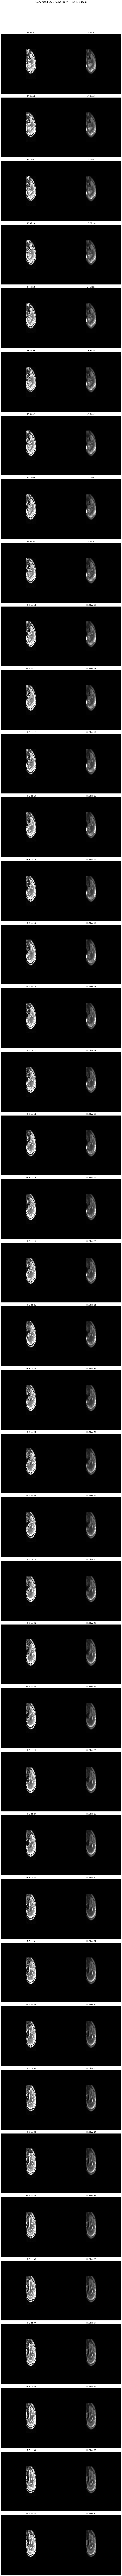

In [ ]:
import matplotlib.pyplot as plt

num_plots = 40
offset = 0
fig, axes = plt.subplots(
      nrows=num_plots,
      ncols=2,
      figsize=(12, num_plots * 6),  # Adjust figure size based on number of plots
      dpi=100,
)
if num_plots == 1:
    axes = axes[np.newaxis, :]
fig.suptitle(
    f"Generated vs. Ground Truth (First {num_plots} Slices)", fontsize=16, y=1.02
)
for i in range(num_plots):
    data = ds[offset+i]
    ax_gt = axes[i, 0]
    # Ground Truth is typically grayscale (H, W), use 'gray' colormap
    # We assume the HR slices have been normalized to [0, 1] or similar
    ax_gt.imshow(np.squeeze(data['hr']), cmap='gray')
    ax_gt.set_title(f"HR Slice {i+1}", fontsize=12)
    ax_gt.axis("off")
    ax_lr = axes[i,1]
    ax_lr.imshow(np.squeeze(data['lr']), cmap='gray')
    ax_lr.set_title(f"LR Slice {i+1}", fontsize=12)
    ax_lr.axis("off")
plt.tight_layout(rect=[0, 0, 1, 1.01])  # Adjust layout to make space for suptitle
plt.show()

In [ ]:
import numpy as np, torch
from collections import Counter

def inspect_sample(sample):
    hr = sample['hr']
    lr = sample['lr']
    # convert to numpy (handle torch tensors)
    if isinstance(hr, torch.Tensor): hr = hr.detach().cpu().numpy()
    if isinstance(lr, torch.Tensor): lr = lr.detach().cpu().numpy()

    print("HR shape:", hr.shape, "LR shape:", lr.shape, " dtype:", hr.dtype)
    print("HR min/max/mean:", float(np.nanmin(hr)), float(np.nanmax(hr)), float(np.nanmean(hr)))
    print("LR min/max/mean:", float(np.nanmin(lr)), float(np.nanmax(lr)), float(np.nanmean(lr)))
    print("HR NaNs:", int(np.isnan(hr).sum()), "LR NaNs:", int(np.isnan(lr).sum()))
    print("HR unique (sample):", np.unique(hr.ravel()[:200]).tolist())
    # quick histogram (coarse)
    hist, edges = np.histogram(hr.ravel(), bins=10)
    print("HR hist bins:", hist, "edges:", np.round(edges,4))

# inspect first 5 slices
for i in range(5):
    print("=== SAMPLE", i, "===")
    inspect_sample(ds[i+offset])


=== SAMPLE 0 ===
HR shape: (1, 512, 512) LR shape: (1, 512, 512)  dtype: float32
HR min/max/mean: 0.0 1.0 0.03689414635300636
LR min/max/mean: 0.0 1.0 0.019816795364022255
HR NaNs: 0 LR NaNs: 0
HR unique (sample): [0.0]
HR hist bins: [247767   1183   1224    902   1262   1574   1293   1263   1272   4404] edges: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
=== SAMPLE 1 ===
HR shape: (1, 512, 512) LR shape: (1, 512, 512)  dtype: float32
HR min/max/mean: 0.0 1.0 0.03705020621418953
LR min/max/mean: 0.0 1.0 0.019893493503332138
HR NaNs: 0 LR NaNs: 0
HR unique (sample): [0.0]
HR hist bins: [247622   1206   1243    903   1361   1542   1283   1375   1258   4351] edges: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
=== SAMPLE 2 ===
HR shape: (1, 512, 512) LR shape: (1, 512, 512)  dtype: float32
HR min/max/mean: 0.0 1.0 0.037352997809648514
LR min/max/mean: 0.0 1.0 0.019961616024374962
HR NaNs: 0 LR NaNs: 0
HR unique (sample): [0.0]
HR hist bins: [247482   1250   1196    872   1387   1652   13

### LoRA Finetuning

In [ ]:
from peft import LoraConfig, get_peft_model
import glob

output_dir = Path(args.output_dir, "./lora")
logging_dir = output_dir / args.logging_dir
accelerator_project_config = ProjectConfiguration(project_dir=output_dir, logging_dir=logging_dir)
accelerator = Accelerator(
    gradient_accumulation_steps=args.gradient_accumulation_steps,
    mixed_precision=args.mixed_precision,
    log_with=args.report_to,
    project_config=accelerator_project_config,
)
set_seed(args.seed)
os.makedirs(output_dir, exist_ok=True)

# Text Encoders
text_encoder_cls = import_model_class_from_model_name_or_path(
    args.pretrained_model_name_or_path, args.revision, subfolder="text_encoder"
)

text_encoder = text_encoder_cls.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="text_encoder", revision=args.revision
)

# Variational Autoencoder Path
vae_path = (
    args.pretrained_model_name_or_path
    if args.pretrained_vae_model_name_or_path is None
    else args.pretrained_vae_model_name_or_path
)

# 1. Load standard models
tokenizer = AutoTokenizer.from_pretrained(args.pretrained_model_name_or_path, subfolder="tokenizer")
noise_scheduler = DDPMScheduler.from_pretrained(args.pretrained_model_name_or_path, subfolder="scheduler")
vae = AutoencoderKL.from_pretrained(vae_path, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(args.pretrained_model_name_or_path, subfolder="unet")

# 2. Freeze all models
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.requires_grad_(False)

# 3. Define LoRA Configuration
# We target attention layers (to, from, out queries/values) which is standard for SD
unet_lora_config = LoraConfig(
    r=args.lora_rank,  # usually 8, 16, or 32
    lora_alpha=args.lora_alpha,
    init_lora_weights="gaussian",
    target_modules=["to_k", "to_q", "to_v", "to_out.0"],
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [ ]:
# 4. Resume Logic: Check for existing LoRA weights
resume_path = os.path.join(output_dir, "lora_weights")
checkpoint_dirs = glob.glob(os.path.join(output_dir, "checkpoint-lora-*"))

initial_global_step = 0

if os.path.exists(resume_path):
    print(f"Found existing LoRA model at {resume_path}. Loading weights...")
    unet.add_adapter(unet_lora_config) # Initialize structure
    # Load the state dict from the saved folder
    state_dict = torch.load(os.path.join(resume_path, "pytorch_lora_weights.bin"), map_location="cpu")
    set_peft_model_state_dict(unet, state_dict)
elif checkpoint_dirs:
    # Sort by step number to get the latest
    latest_checkpoint = sorted(checkpoint_dirs, key=lambda x: int(x.split("-")[-1]))[-1]
    initial_global_step = int(latest_checkpoint.split("-")[-1])
    print(f"Found checkpoint at {latest_checkpoint}. Resuming from step {initial_global_step}...")
    unet.add_adapter(unet_lora_config)
    # diffusers load_attn_procs can be used here too
    unet.load_attn_procs(latest_checkpoint)
else:
    print("No existing model or checkpoint found. Starting from scratch.")
    unet.add_adapter(unet_lora_config)

# Ensure only LoRA params are trainable
trainable_params = filter(lambda p: p.requires_grad, unet.parameters())

Found checkpoint at /content/drive/MyDrive/GenAI/artificial-lora/lora/checkpoint-lora-800. Resuming from step 800...


/usr/local/lib/python3.12/dist-packages/diffusers/loaders/unet.py:214: FutureWarning: `load_attn_procs` is deprecated and will be removed in version 0.40.0. Using the `load_attn_procs()` method has been deprecated and will be removed in a future version. Please use `load_lora_adapter()`.
  deprecate("load_attn_procs", "0.40.0", deprecation_message)
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [ ]:
if args.scale_lr:
    learning_rate = (
        args.learning_rate * args.gradient_accumulation_steps * args.train_batch_size * accelerator.num_processes
    )
else:
    learning_rate = args.learning_rate

if args.use_8bit_adam:
    import bitsandbytes as bnb
    optimizer_class = bnb.optim.AdamW8bit
else:
    optimizer_class = torch.optim.AdamW

In [ ]:
# Optimizer only needs to see the unet (it will only find LoRA parameters)
optimizer = optimizer_class(
    unet.parameters(),
    lr=learning_rate,
    betas=(args.adam_beta1, args.adam_beta2),
    weight_decay=args.adam_weight_decay,
    eps=args.adam_epsilon,
)

lr_scheduler = get_scheduler(
    args.lr_scheduler_name,
    optimizer=optimizer,
    num_warmup_steps=args.lr_warmup_steps * accelerator.num_processes,
    num_training_steps=args.max_train_steps * accelerator.num_processes,
)

# Move to device
weight_dtype = torch.float32
if accelerator.mixed_precision == "fp16":
    weight_dtype = torch.float16

vae.to(accelerator.device, dtype=torch.float32) # VAE often safer in float32
text_encoder.to(accelerator.device, dtype=weight_dtype)
unet.to(accelerator.device, dtype=weight_dtype)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): lora.Linear(
                  (base_layer): Linear(in_features=320, out_features=320, bias=False)
                  (lora_dropout): ModuleDict(
                    (default): Identity()

In [ ]:
import torch
import gc

# Let's first compute all the embeddings so that we can free up the text encoders from memory.
text_encoders = [text_encoder]
tokenizers = [tokenizer]

# Dictionary to store pre-computed embeddings
precomputed_embeddings = {}

print("Pre-computing text embeddings...")
unet.eval() # Keep UNet in eval mode while using encoders

for step, batch in enumerate(train_loader):
    with torch.no_grad():
        # Use your existing function to get embeddings
        # We use batch index or a unique ID from the batch as a key
        payload = compute_embeddings_sd1x5(
            batch=batch,
            proportion_empty_prompts=0.0, # Usually 0 during pre-compute
            text_encoders=text_encoders,
            tokenizers=tokenizers
        )
        # Store on CPU to save GPU VRAM
        precomputed_embeddings[step] = payload['prompt_embeds'].cpu()

# NOW: Free the memory as your comment originally intended
del text_encoder
del tokenizer
del text_encoders
del tokenizers

gc.collect()
torch.cuda.empty_cache()
print("Text encoders removed. Memory cleared!")

# Prepare with accelerator
unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    unet, optimizer, train_loader, lr_scheduler
)

Pre-computing text embeddings...
Text encoders removed. Memory cleared!


In [ ]:
# Before starting the loop, calculate how many steps are left
global_step = initial_global_step
# If resuming, calculate which epoch we should be in
first_epoch = initial_global_step // (len(train_loader) // args.gradient_accumulation_steps)

progress_bar = tqdm(
    range(0, args.max_train_steps),
    initial=initial_global_step,
    desc='Steps',
    disable=not accelerator.is_local_main_process
)

loss_history = []

for epoch in range(args.num_train_epochs):
    unet.train()
    for step, batch in enumerate(train_loader):
        with accelerator.accumulate(unet):
            bsz = batch['hr'].shape[0]

            # 1. Encode HR (Target)
            hr_slices = batch['hr'].to(accelerator.device, dtype=vae.dtype).expand(bsz, 3, -1, -1)
            latents = vae.encode(hr_slices).latent_dist.sample() * vae.config.scaling_factor
            latents = latents.to(weight_dtype)

            # 2. Encode LR (Conditioning)
            # In LoRA SR, we often concatenate the LR latents to the noisy latents
            # or use them as a starting point. Here we follow standard LoRA tuning:
            lr_slices = batch['lr'].to(accelerator.device, dtype=vae.dtype).expand(bsz, 3, -1, -1)
            lr_latents = vae.encode(lr_slices).latent_dist.sample() * vae.config.scaling_factor
            lr_latents = lr_latents.to(weight_dtype)

            # 3. Add noise to HR latents
            noise = torch.randn_like(latents)
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device).long()
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # 4. Text Embedding - We have moved this to pre-computation
            # prompt_embeds = compute_embeddings_sd1x5(
            #     batch=batch, proportion_empty_prompts=0.1, text_encoders=text_encoders, tokenizers=tokenizers
            # )['prompt_embeds']
            prompt_embeds = precomputed_embeddings[step].to(accelerator.device, dtype=weight_dtype)

            # 5. Predict (LoRA layers inside unet are active)
            # We "condition" by concatenating the LR latents to the input
            # If your UNet wasn't modified for 8-channel input, you would
            # sum the LR latents or use them as the noisy_latents starting point.
            model_input = torch.cat([noisy_latents, lr_latents], dim=1) if unet.config.in_channels == 8 else noisy_latents + lr_latents

            model_pred = unet(model_input, timesteps, encoder_hidden_states=prompt_embeds).sample

            # 6. Loss & Backward
            if noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(latents, noise, timesteps)
            else:
                target = noise

            loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")
            loss_history.append(loss.detach().item())
            accelerator.backward(loss)

            if accelerator.sync_gradients:
                params_to_clip = unet.parameters()
                accelerator.clip_grad_norm_(params_to_clip, args.max_grad_norm)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

                if accelerator.is_main_process and global_step % args.checkpointing_steps == 0:
                    save_path = os.path.join(output_dir, f"checkpoint-lora-{global_step}")
                    # Save only LoRA weights
                    unwrapped_unet = accelerator.unwrap_model(unet)
                    unwrapped_unet.save_attn_procs(save_path)
                if global_step >= args.max_train_steps:
                  break

        logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
        progress_bar.set_postfix(**logs)

Steps:  40%|####      | 800/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/diffusers/loaders/unet.py:484: FutureWarning: `save_attn_procs` is deprecated and will be removed in version 0.40.0. Using the `save_attn_procs()` method has been deprecated and will be removed in a future version. Please use `save_lora_adapter()`.
  deprecate("save_attn_procs", "0.40.0", deprecation_message)


In [ ]:
if accelerator.is_main_process:
    # Save the final LoRA weights (small .safetensors file)
    unwrapped_unet = accelerator.unwrap_model(unet)
    unwrapped_unet.save_attn_procs(os.path.join(output_dir, "lora_weights"))
    print("LoRA training finished.")

LoRA training finished.


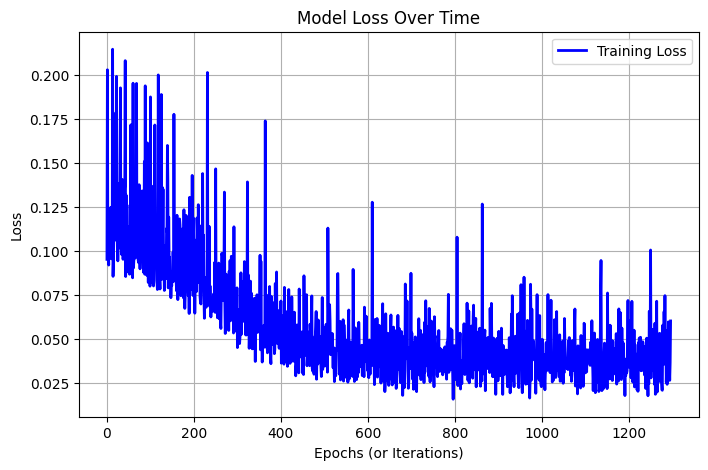

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(loss_history, label='Training Loss', color='blue', linewidth=2)

# Adding labels and title
plt.title('Model Loss Over Time')
plt.xlabel('Epochs (or Iterations)')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

### Load ControlNET Models

In [ ]:
output_dir = Path(args.output_dir, "./controlnet")
logging_dir = output_dir / args.logging_dir
accelerator_project_config = ProjectConfiguration(project_dir=output_dir, logging_dir=logging_dir)
accelerator = Accelerator(
    gradient_accumulation_steps=args.gradient_accumulation_steps,
    mixed_precision=args.mixed_precision,
    log_with=args.report_to,
    project_config=accelerator_project_config,
)
set_seed(args.seed)
os.makedirs(output_dir, exist_ok=True)

# Load Tokenizers
tokenizer = AutoTokenizer.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="tokenizer", revision=args.revision, use_fast=False
)

# Load Scheduler
noise_scheduler = DDPMScheduler.from_pretrained(
    args.pretrained_model_name_or_path,
    subfolder="scheduler",
    prediction_type="v_prediction",
    timestep_spacing="trailing",
    rescale_betas_zero_snr=True
)

# Load Text Encoders
text_encoder_cls = import_model_class_from_model_name_or_path(
    args.pretrained_model_name_or_path, args.revision, subfolder="text_encoder"
)

text_encoder = text_encoder_cls.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="text_encoder", revision=args.revision
)


# Load VAE
vae_path = (
    args.pretrained_model_name_or_path
    if args.pretrained_vae_model_name_or_path is None
    else args.pretrained_vae_model_name_or_path
)
vae = AutoencoderKL.from_pretrained(
    vae_path,
    subfolder="vae" if args.pretrained_vae_model_name_or_path is None else None,
    revision=args.revision,
)

# Load UNet
unet = UNet2DConditionModel.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="unet", revision=args.revision
)

# Load ControlNET before LoRA because of ControlNetModel.from_unet expects default unet.
from diffusers import ControlNetModel
controlnet = ControlNetModel.from_unet(unet)

lora_model_path = os.path.join(args.output_dir, "lora/lora_weights")
unet.load_attn_procs(lora_model_path)
print(f"Successfully loaded LoRA weights from {lora_model_path}")

# Freeze VAE, Text Encoder, and UNet. Only ControlNet is trained.
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.requires_grad_(False)
controlnet.requires_grad_(True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/diffusers/loaders/unet.py:214: FutureWarning: `load_attn_procs` is deprecated and will be removed in version 0.40.0. Using the `load_attn_procs()` method has been deprecated and will be removed in a future version. Please use `load_lora_adapter()`.
  deprecate("load_attn_procs", "0.40.0", deprecation_message)
Loading adapter weights from state_dict led to unexpected keys found in the model: down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_A.default_0.default_1.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_B.default_0.default_1.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.lora_A.default_0.default_1.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.lora_B.default_0.default_1.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.lora_A.default_0.default_1.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.lora_B.default_0.default_1.weight, do

Successfully loaded LoRA weights from /content/drive/MyDrive/GenAI/artificial-lora/lora/lora_weights


ControlNetModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (controlnet_cond_embedding): ControlNetConditioningEmbedding(
    (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (blocks): ModuleList(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(32, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (conv_out): Conv2d(256, 320, ker

In [ ]:
if args.enable_xformers_memory_efficient_attention:
    import xformers
    controlnet.enable_xformers_memory_efficient_attention()
    unet.enable_xformers_memory_efficient_attention()

if args.gradient_checkpointing:
    controlnet.enable_gradient_checkpointing()

if args.allow_tf32:
    torch.backends.cuda.matmul.allow_tf32 = True

if args.scale_lr:
    learning_rate = (
        args.learning_rate * args.gradient_accumulation_steps * args.train_batch_size * accelerator.num_processes
    )
else:
    learning_rate = args.learning_rate

if args.use_8bit_adam:
    import bitsandbytes as bnb
    optimizer_class = bnb.optim.AdamW8bit
else:
    optimizer_class = torch.optim.AdamW

In [ ]:
f"Learning Rate is {learning_rate}"

'Learning Rate is 1e-05'

In [ ]:
# ControlNet training usually freezes the UNet entirely
params_to_optimize = list(controlnet.parameters())

optimizer = optimizer_class(
    params_to_optimize,
    lr=learning_rate,
    betas=(args.adam_beta1, args.adam_beta2),
    weight_decay=args.adam_weight_decay,
    eps=args.adam_epsilon,
)

In [ ]:
# For mixed precision training we cast the text_encoder and vae weights to half-precision
# as these models are only used for inference, keeping weights in full precision is not required.
weight_dtype = torch.float32
if accelerator.mixed_precision == "fp16":
    weight_dtype = torch.float16
elif accelerator.mixed_precision == "bf16":
    weight_dtype = torch.bfloat16

# Move vae, unet and text_encoder to device and cast to weight_dtype
# The VAE is in float32 to avoid NaN losses.
if args.pretrained_vae_model_name_or_path is not None:
    vae.to(accelerator.device, dtype=weight_dtype)
else:
    vae.to(accelerator.device, dtype=torch.float32)

unet.to(accelerator.device, dtype=weight_dtype)
text_encoder.to(accelerator.device, dtype=weight_dtype)
controlnet.to(accelerator.device, dtype=torch.float32)

ControlNetModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (controlnet_cond_embedding): ControlNetConditioningEmbedding(
    (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (blocks): ModuleList(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(32, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (conv_out): Conv2d(256, 320, ker

In [ ]:
# Let's first compute all the embeddings so that we can free up the text encoders
# from memory.
text_encoders = [text_encoder]
tokenizers = [tokenizer]
gc.collect()
torch.cuda.empty_cache()

num_update_steps_per_epoch = math.ceil(1e7 / args.gradient_accumulation_steps)
if args.max_train_steps is None:
    args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    args.lr_scheduler_name,
    optimizer=optimizer,
    num_warmup_steps=args.lr_warmup_steps * accelerator.num_processes,
    num_training_steps=args.max_train_steps * accelerator.num_processes,
)

# EMA for ControlNet instead of UNet/Adapter
ema_controlnet = EMAModel(
    controlnet.parameters(),
    model_cls=ControlNetModel,
    model_config=controlnet.config,
    decay=0.9999
)

controlnet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    controlnet, optimizer, train_loader, lr_scheduler
)

total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

### Training

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir "./logs/controlnet"

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2026-01-14 10:50:39.368817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768387839.403972    4031 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768387839.413701    4031 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768387839.441391    4031 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768387839.441442    4031 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:17

In [ ]:
# If we already have trained a model and want to continue training
# controlnet = ControlNetModel.from_pretrained(os.path.join(args.output_dir, "controlnet_tuned"))

In [ ]:
global_step = 0
first_epoch = 0
initial_global_step = 0
loss_history = []

progress_bar = tqdm(
    range(0, args.max_train_steps),
    initial=initial_global_step,
    desc='Steps',
    disable=not accelerator.is_local_main_process
)

for epoch in range(first_epoch, args.num_train_epochs):
    controlnet.train()

    for step, batch in enumerate(train_loader):
        with accelerator.accumulate(controlnet):
            bsz = batch['hr'].shape[0]
            h, w = batch['hr'].shape[-2:]

            # Prepare inputs
            hr_slices = batch['hr'].to(accelerator.device, dtype=vae.dtype)
            hr_slices = hr_slices.expand(bsz, 3, h, w)

            lr_slices = batch['lr'].to(accelerator.device, dtype=weight_dtype)
            condition = lr_slices.expand(bsz, 3, h, w)

            # VAE Encoding
            latents = vae.encode(hr_slices).latent_dist.sample()
            latents = latents * vae.config.scaling_factor
            latents = latents.to(weight_dtype)

            if args.pretrained_vae_model_name_or_path is None:
               latents = latents.to(weight_dtype)

            # Noise generation
            noise = torch.randn_like(latents)
            bsz = latents.shape[0]
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device).long()
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Text Embedding
            prompt_embeds = compute_embeddings_sd1x5(
                batch=batch, proportion_empty_prompts=0.1, text_encoders=text_encoders, tokenizers=tokenizers
            )['prompt_embeds']

            # --- ControlNet Forward Pass (Input cast to float32) ---
            down_block_res, mid_block_res = controlnet(
                noisy_latents.to(torch.float32),
                timesteps,
                encoder_hidden_states=prompt_embeds.to(torch.float32),
                controlnet_cond=condition.to(torch.float32),
                return_dict=False,
            )

            # --- UNet Forward Pass (Residuals cast back to weight_dtype) ---
            model_pred = unet(
                noisy_latents,
                timesteps,
                encoder_hidden_states=prompt_embeds,
                down_block_additional_residuals=[
                    sample.to(weight_dtype) for sample in down_block_res
                ],
                mid_block_additional_residual=mid_block_res.to(weight_dtype),
            ).sample

            # Loss Calculation
            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(latents, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

            loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")
            loss_history.append(loss.detach().item())

            accelerator.backward(loss)

            if accelerator.sync_gradients:
                accelerator.clip_grad_norm_(controlnet.parameters(), args.max_grad_norm)
                optimizer.step()
                lr_scheduler.step()
                if accelerator.is_main_process:
                    unwrapped_controlnet = accelerator.unwrap_model(controlnet)
                    ema_controlnet.step(unwrapped_controlnet.parameters())
                optimizer.zero_grad()

            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

                if accelerator.is_main_process and global_step % args.checkpointing_steps == 0:
                    save_path = os.path.join(output_dir, f"checkpoint-{global_step}")
                    unwrapped_controlnet = accelerator.unwrap_model(controlnet)
                    unwrapped_controlnet.save_pretrained(save_path)
                    print(f"Saved checkpoint to {save_path}")
                if global_step >= args.max_train_steps:
                  break

        logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
        progress_bar.set_postfix(**logs)

Steps:   0%|          | 0/2000 [00:00<?, ?it/s]

Saved checkpoint to /content/drive/MyDrive/GenAI/artificial-lora/controlnet/checkpoint-200
Saved checkpoint to /content/drive/MyDrive/GenAI/artificial-lora/controlnet/checkpoint-400
Saved checkpoint to /content/drive/MyDrive/GenAI/artificial-lora/controlnet/checkpoint-600
Saved checkpoint to /content/drive/MyDrive/GenAI/artificial-lora/controlnet/checkpoint-800
Saved checkpoint to /content/drive/MyDrive/GenAI/artificial-lora/controlnet/checkpoint-1000
Saved checkpoint to /content/drive/MyDrive/GenAI/artificial-lora/controlnet/checkpoint-1200
Saved checkpoint to /content/drive/MyDrive/GenAI/artificial-lora/controlnet/checkpoint-1400
Saved checkpoint to /content/drive/MyDrive/GenAI/artificial-lora/controlnet/checkpoint-1600
Saved checkpoint to /content/drive/MyDrive/GenAI/artificial-lora/controlnet/checkpoint-1800
Saved checkpoint to /content/drive/MyDrive/GenAI/artificial-lora/controlnet/checkpoint-2000


In [ ]:
if accelerator.is_main_process:
    # Extract model from wrapper
    unwrapped_controlnet = accelerator.unwrap_model(controlnet)
    # Swap the "last step" weights for the "smoothed average" weights.
    ema_controlnet.copy_to(unwrapped_controlnet.parameters())
    # Save model
    unwrapped_controlnet.save_pretrained(os.path.join(args.output_dir, "controlnet_tuned"))
    print("Training finished. Saved final EMA ControlNet.")

Training finished. Saved final EMA ControlNet.


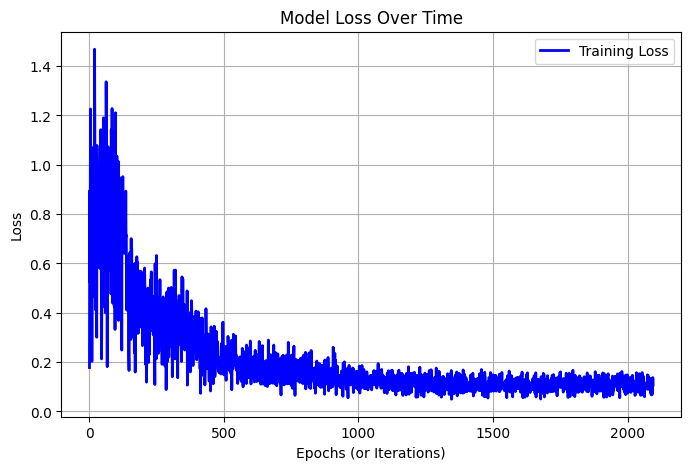

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(loss_history, label='Training Loss', color='blue', linewidth=2)

# Adding labels and title
plt.title('Model Loss Over Time')
plt.xlabel('Epochs (or Iterations)')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

### Evaluation

In [ ]:
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from skimage.filters import gaussian, laplace
from accelerate import Accelerator
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UNet2DConditionModel, DDPMScheduler, AutoencoderKL
from transformers import AutoTokenizer

# Initialize Accelerator
accelerator = Accelerator(mixed_precision="fp16")
device = accelerator.device
weight_dtype = torch.float16 if accelerator.mixed_precision == "fp16" else torch.float32

# 1. Load Components
controlnet = ControlNetModel.from_pretrained(
    os.path.join(args.output_dir, "controlnet_tuned"),
    torch_dtype=weight_dtype
).to(device)

unet = UNet2DConditionModel.from_pretrained(
    args.pretrained_model_name_or_path,
    subfolder="unet",
    torch_dtype=weight_dtype
).to(device)

lora_model_path = os.path.join(args.output_dir, "lora/lora_weights")
unet.load_attn_procs(lora_model_path)
print(f"Successfully loaded LoRA weights from {lora_model_path}")

# 3. Build the pipeline
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    args.pretrained_model_name_or_path,
    controlnet=controlnet,
    unet=unet,
    torch_dtype=torch.float16
).to("cuda")

pipe.scheduler = DDPMScheduler.from_pretrained(
    args.pretrained_model_name_or_path,
    subfolder="scheduler",
    prediction_type="v_prediction",
    rescale_betas_zero_snr=True
)

vae_path = (
    args.pretrained_model_name_or_path
    if args.pretrained_vae_model_name_or_path is None
    else args.pretrained_vae_model_name_or_path
)
vae = AutoencoderKL.from_pretrained(
    vae_path,
    subfolder="vae" if args.pretrained_vae_model_name_or_path is None else None,
    revision=args.revision,
)

noise_scheduler = DDPMScheduler.from_pretrained(
    args.pretrained_model_name_or_path,
    subfolder="scheduler",
    prediction_type="v_prediction",
    timestep_spacing="trailing",
    rescale_betas_zero_snr=True
)

text_encoder_cls = import_model_class_from_model_name_or_path(
    args.pretrained_model_name_or_path, args.revision, subfolder="text_encoder"
)

text_encoder = text_encoder_cls.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="text_encoder", revision=args.revision
)

tokenizer = AutoTokenizer.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="tokenizer", revision=args.revision, use_fast=False
)

text_encoders = [text_encoder]
tokenizers = [tokenizer]

controlnet.to(accelerator.device, dtype=weight_dtype)
unet.to(accelerator.device, dtype=weight_dtype)
vae.to(accelerator.device, dtype=weight_dtype) # or float32 if you prefer
text_encoder.to(accelerator.device, dtype=weight_dtype)

controlnet.eval()
unet.eval()
vae.eval()

/usr/local/lib/python3.12/dist-packages/diffusers/loaders/unet.py:214: FutureWarning: `load_attn_procs` is deprecated and will be removed in version 0.40.0. Using the `load_attn_procs()` method has been deprecated and will be removed in a future version. Please use `load_lora_adapter()`.
  deprecate("load_attn_procs", "0.40.0", deprecation_message)
Loading adapter weights from state_dict led to unexpected keys found in the model: down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_A.default_0.default_1.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_B.default_0.default_1.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.lora_A.default_0.default_1.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.lora_B.default_0.default_1.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.lora_A.default_0.default_1.weight, down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.lora_B.default_0.default_1.weight, do

Successfully loaded LoRA weights from /content/drive/MyDrive/GenAI/artificial-lora/lora/lora_weights


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [ ]:
class MRIEvaluator:
    def __init__(self, device):
        self.psnr = PeakSignalNoiseRatio(data_range=1.0).to(device)
        self.ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

    def compute_hfen(self, pred, target, sigma=1.5):
        lo_g_pred = laplace(gaussian(pred, sigma=sigma))
        lo_g_target = laplace(gaussian(target, sigma=sigma))
        return np.linalg.norm(lo_g_pred - lo_g_target) / (np.linalg.norm(lo_g_target) + 1e-8)

    def compute_nmse(self, pred, target):
        mse = np.linalg.norm(pred - target) ** 2
        norm_gt = np.linalg.norm(target) ** 2
        return mse / (norm_gt + 1e-8)

def _masked_percentile_map(gen, gt, pmin=1.0, pmax=99.0):
    """Maps generation contrast to GT contrast for visualization."""
    gen_gray = gen.mean(axis=2) if gen.ndim == 3 else gen
    gt_gray = gt.squeeze()

    # Simple foreground mask
    mask = gt_gray > np.percentile(gt_gray, 3.0)
    if mask.sum() == 0: mask = np.ones_like(gt_gray, dtype=bool)

    g_pmin, g_pmax = np.percentile(gen_gray[mask], [pmin, pmax])
    t_pmin, t_pmax = np.percentile(gt_gray[mask], [pmin, pmax])

    gen_norm = np.clip((gen_gray - g_pmin) / (g_pmax - g_pmin + 1e-8), 0.0, 1.0)
    mapped = gen_norm * (t_pmax - t_pmin) + t_pmin
    return np.clip((mapped - t_pmin) / (t_pmax - t_pmin + 1e-8), 0.0, 1.0)

def plot_mri_results(vis_data, num_images=6):
    fig, axes = plt.subplots(num_images, 4, figsize=(16, num_images * 4))
    for i in range(num_images):
        axes[i, 0].imshow(vis_data["lr"][i].squeeze(), cmap='gray')
        axes[i, 0].set_title("Input (LR)")
        axes[i, 1].imshow(vis_data["raw"][i], cmap='gray')
        axes[i, 1].set_title("Generated (Raw)")
        axes[i, 2].imshow(vis_data["post"][i], cmap='gray')
        axes[i, 2].set_title("Generated (Mapped)")
        axes[i, 3].imshow(vis_data["gt"][i].squeeze(), cmap='gray')
        axes[i, 3].set_title("Ground Truth (HR)")
        for ax in axes[i]: ax.axis('off')
    plt.tight_layout()
    plt.show()

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]


VALIDATION RESULTS:
--------------------
PSNR: 6.4510
SSIM: 0.0060
HFEN: 1.0761
NMSE: 16.3936


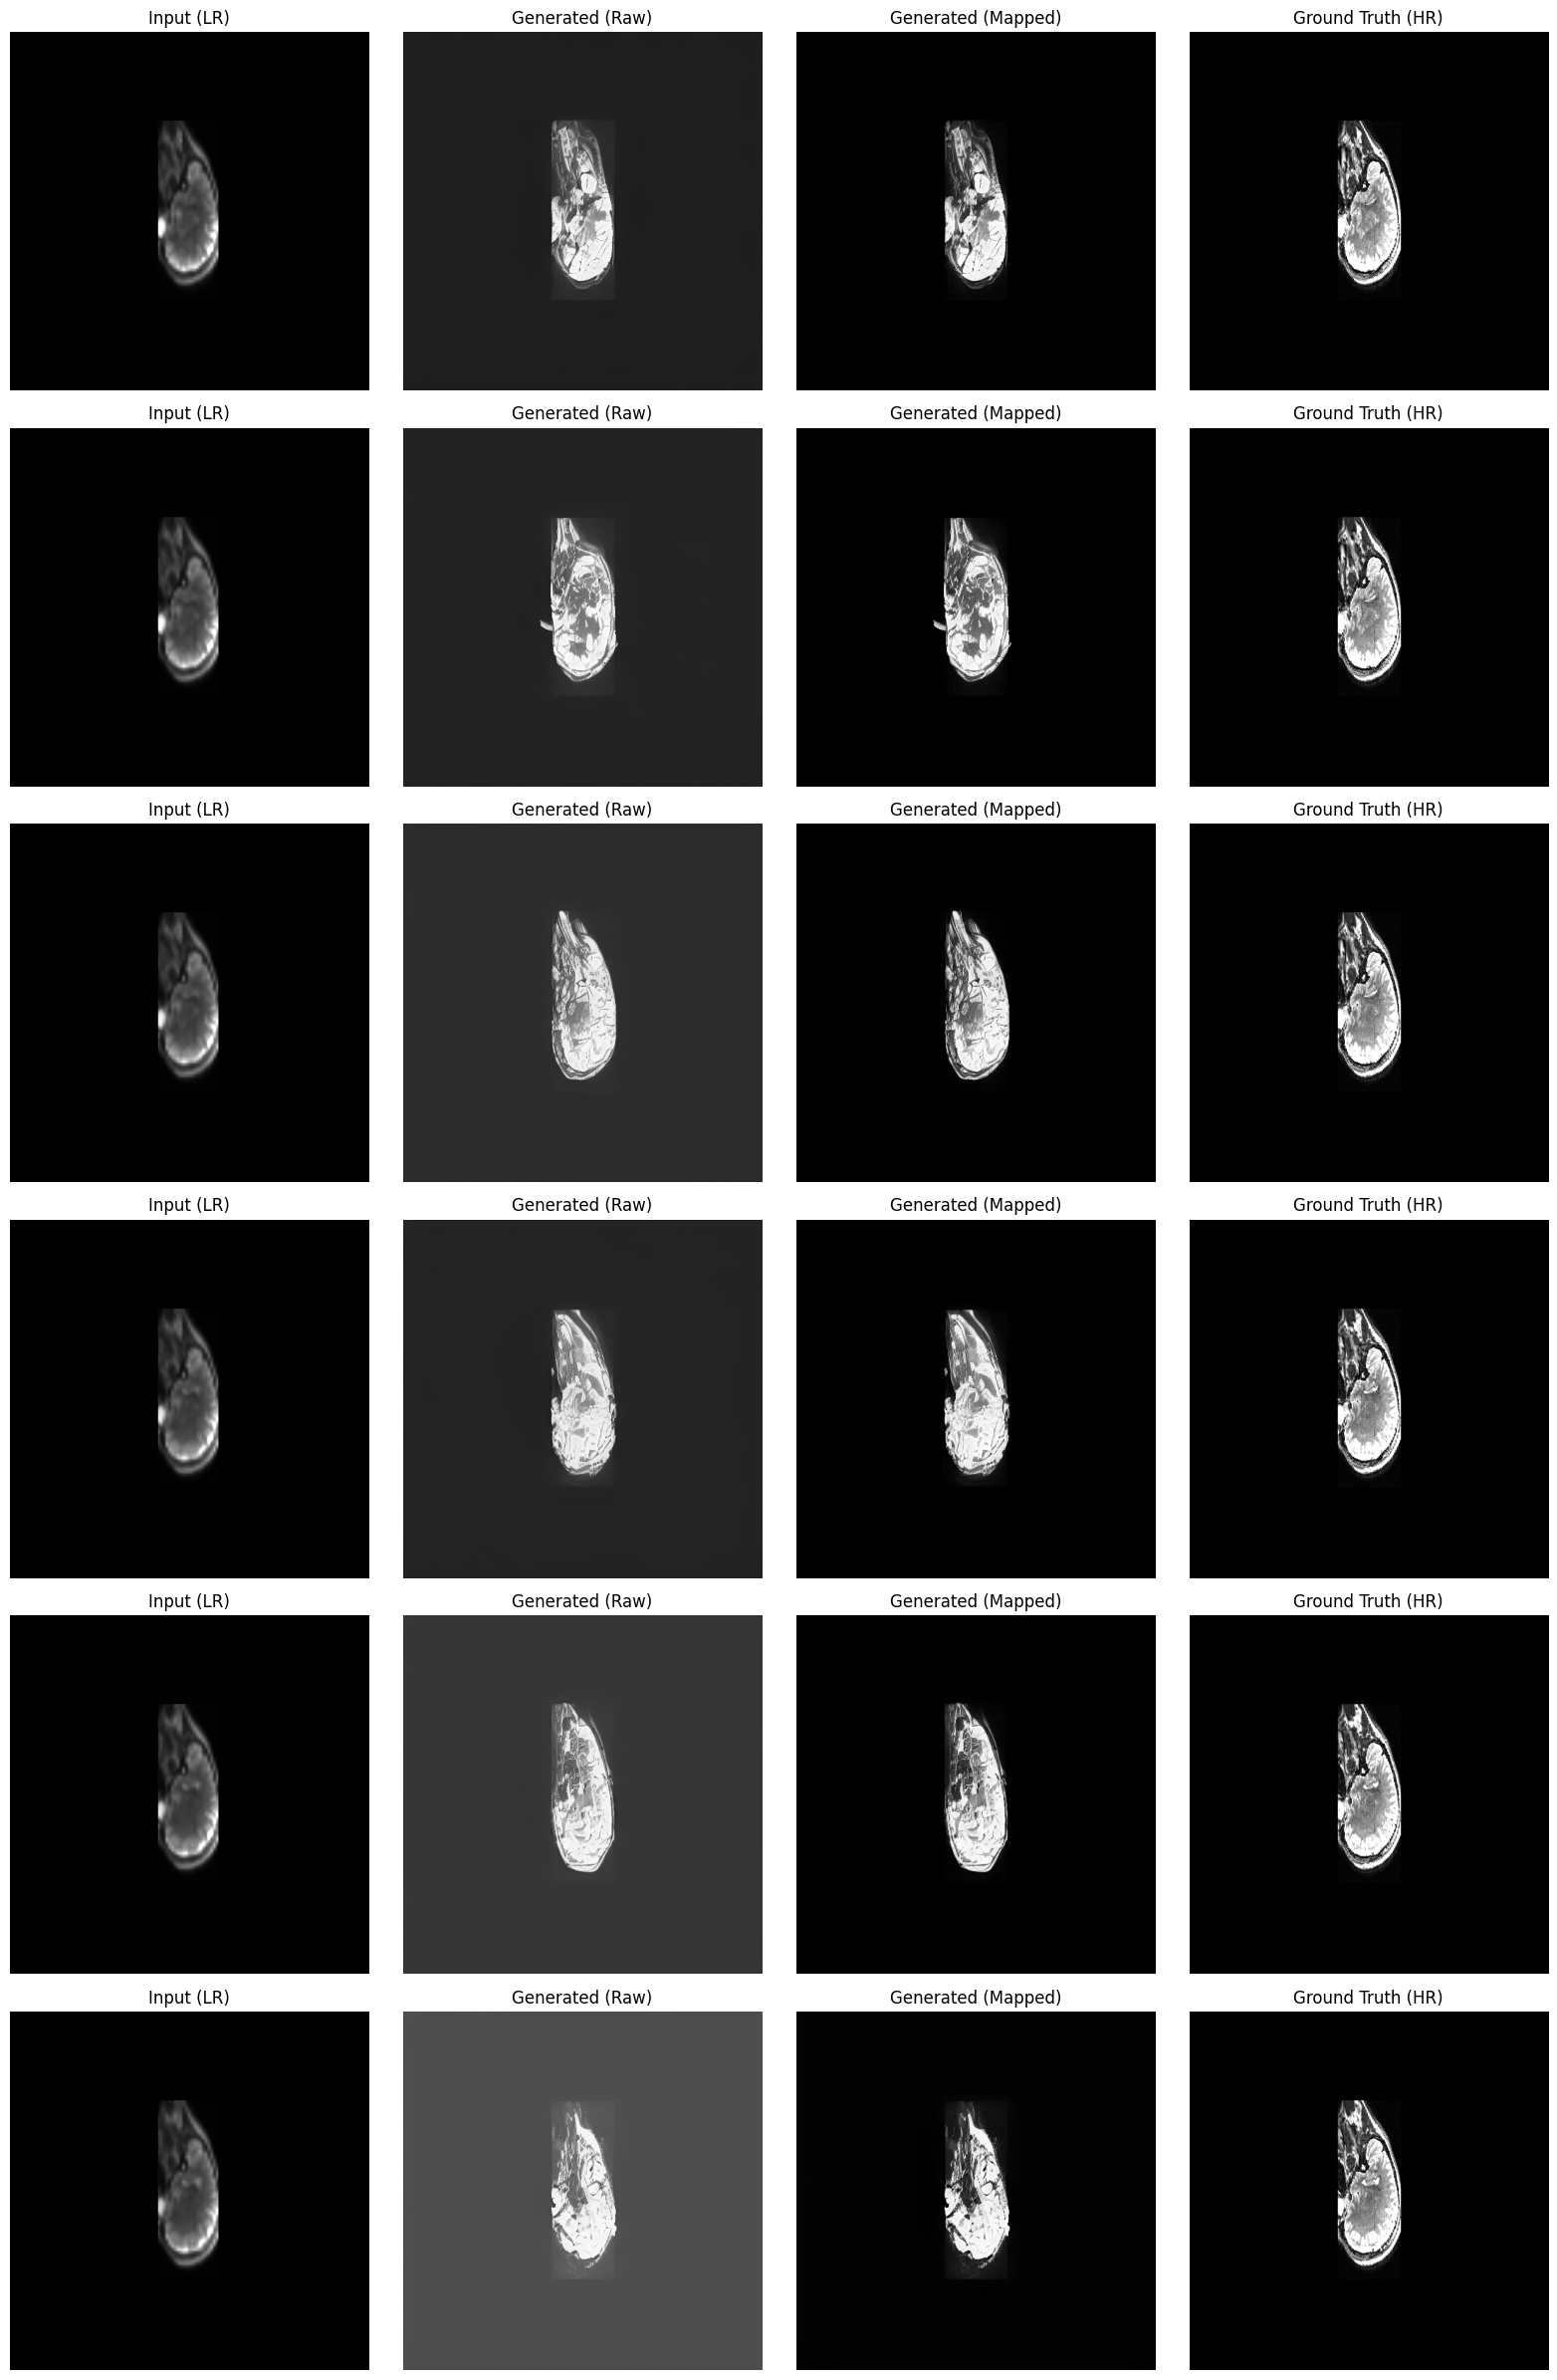

In [ ]:
evaluator = MRIEvaluator(accelerator.device)
all_metrics = []
vis_samples = {"lr": [], "raw": [], "post": [], "gt": []}

for batch in tqdm(val_loader, desc="Evaluating"):
    bsz = batch["hr"].shape[0]
    h, w = batch["hr"].shape[-2:]

    # 1. Prepare Latents & Embeddings
    prompt_embeds = compute_embeddings_sd1x5(batch, 0.0, text_encoders, tokenizers)["prompt_embeds"].to(device, dtype=weight_dtype)
    condition = batch["lr"].to(device, dtype=weight_dtype).expand(bsz, 3, h, w)

    noise_scheduler.set_timesteps(50)
    latents = torch.randn((bsz, 4, h//8, w//8), device=device, dtype=weight_dtype) * noise_scheduler.init_noise_sigma

    # 2. Diffusion Loop
    with torch.no_grad():
        for t in noise_scheduler.timesteps:
            latent_input = noise_scheduler.scale_model_input(latents, t)
            down_res, mid_res = controlnet(latent_input, t, prompt_embeds, condition, return_dict=False)
            noise_pred = unet(latent_input, t, prompt_embeds,
                              down_block_additional_residuals=[r.to(weight_dtype) for r in down_res],
                              mid_block_additional_residual=mid_res.to(weight_dtype)).sample
            latents = noise_scheduler.step(noise_pred, t, latents).prev_sample

        # 3. Decode
        latents = latents / vae.config.scaling_factor
        raw_gen = (vae.decode(latents).sample / 2.0 + 0.5).clamp(0.0, 1.0)

    # 4. Metrics & Visualization Processing
    hr_gt_np = batch["hr"].cpu().numpy()
    raw_gen_np = raw_gen.cpu().permute(0, 2, 3, 1).float().numpy()

    for i in range(bsz):
        gen_img = raw_gen_np[i].mean(axis=2)
        gt_img = hr_gt_np[i].squeeze()

        # Quantitative Metrics
        t_gen = torch.from_numpy(gen_img).unsqueeze(0).unsqueeze(0).to(device)
        t_gt = torch.from_numpy(gt_img).unsqueeze(0).unsqueeze(0).to(device)

        all_metrics.append({
            "PSNR": evaluator.psnr(t_gen, t_gt).item(),
            "SSIM": evaluator.ssim(t_gen, t_gt).item(),
            "HFEN": evaluator.compute_hfen(gen_img, gt_img),
            "NMSE": evaluator.compute_nmse(gen_img, gt_img)
        })

        # Save first 6 samples for plotting
        if len(vis_samples["raw"]) < 6:
            vis_samples["lr"].append(batch["lr"][i].numpy())
            vis_samples["raw"].append(gen_img)
            vis_samples["gt"].append(gt_img)
            vis_samples["post"].append(_masked_percentile_map(raw_gen_np[i], gt_img))

# --- FINAL RESULTS ---
avg_metrics = {k: np.mean([m[k] for m in all_metrics]) for k in all_metrics[0].keys()}
print(f"\nVALIDATION RESULTS:\n{'-'*20}")
for k, v in avg_metrics.items(): print(f"{k}: {v:.4f}")

plot_mri_results(vis_samples, num_images=6)